# Computer Vision (911.908)

## <font color='crimson'>Variational Autoencoders (VAEs)</font>

Roland Kwitt, 2023

In this lecture, we take a closer look at variational autoencoders which essentially establish a connection between graphical models and neural networks. In particular, we review variational inference (VI) for approximating probability densities and then connect this to an neural network architecture that is known as a **variational autoencoder (VAE)**.

The key reference for VAEs is 

[Kingma14a]    
Kingma & Welling    
**Auto-Encoding Variational Bayes**    
ICLR 2014

---

In [15]:
from IPython.display import IFrame
IFrame("./papers/Kingma14a.pdf", width=600, height=300)

---

Say we are given a set $\mathbf{X} = \{ \mathbf{x}_i \}_{i=1}^n$ of realizations of some discrete/continuous variable $\mathbf{x}$ and we assume this data is generated  by some random process, involving an unobserved/latent continuous random variable $\mathbf{z}$. In particular, 

(1) a value $\mathbf{z}_i$ is generated by sampling from a prior $p_{\boldsymbol{\theta}^*}(\mathbf{z})$, and     
(2) a value $\mathbf{x}_i$ is generated from some conditional distribution $p_{\boldsymbol{\theta}^*}(\mathbf{x}|\mathbf{z})$

assuming that $p_{\boldsymbol{\theta}^*}(\mathbf{z})$ and $p_{\boldsymbol{\theta}^*}(\mathbf{x}|\mathbf{z})$ come from some **parametric** family of distributions, $p_{\boldsymbol{\theta}}(\mathbf{z})$ and $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$. Visually the overall process can be described via the **graphical model**

$$\mathbf{z} \rightarrow \mathbf{x}$$

---

The above model specifies how data is generated from the latent (/hidden) variables (which are not observed). **Inference** in such a model amounts to conditioning on data and computing the **posterior** $p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})$, i.e., the conditional density of latent variables given observed variables. Formally, 

$$ p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}) = \frac{p_{\boldsymbol{\theta}}(\mathbf{z})p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})}{p_{\boldsymbol{\theta}}(\mathbf{x})} $$

where the denominator $p(\mathbf{x})$ is called the **evidence**. The problem is that we have

$$ p_{\boldsymbol{\theta}}(\mathbf{x}) = \int p_{\boldsymbol{\theta}}(\mathbf{z})p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}) d\mathbf{z}$$

which is typically intractable and hence the inference problem is quite hard.

*The key idea of variational inference is to phrase the inference problem as an optimization task. Essentially we will choose from a class of tractable posteriors and seek to minimize a notion of distance to the exact posterior.*


In **variational inference**, we aim to approximate $p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})$ by a tractable distribution $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ (parametrized by $\boldsymbol{\phi}$) and seek to solve

$$ \min_{\boldsymbol{\phi}} \text{KL}\big(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) || p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})\big)$$

where KL denotes the **Kullback-Leibler** divergence (i.e., an information theoretic measure of proximity between two densities). In general

$$ \text{KL}(a(x)||b(x)) = \int_x a(x) \log \frac{a(x)}{b(x)} dx$$

for two densities $a$ and $b$.


Upon expanding the KL term using $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ and 
$p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})$ we obtain

\begin{align*}
	\text{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})) & = \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{p_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})}\\
	& = \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})p_{\boldsymbol{\theta}}(\mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})}\\
	& = \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})} + \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log p_{\boldsymbol{\theta}}(\mathbf{x}) \\
	& = - \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})} + \log p_{\boldsymbol{\theta}}(\mathbf{x}) \int_{\mathbf{z}} q_\phi(\mathbf{z}|\mathbf{x}) \\
	& = - \underbrace{\int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}}_{L(\boldsymbol{\phi})} + \log p_{\boldsymbol{\theta}}(\mathbf{x}) \\
	& = -L(\boldsymbol{\phi}) + \log p_{\boldsymbol{\theta}}(\mathbf{x})
\end{align*}



What we see here is that minimizing the KL divergence is equivalent to maximizing $L(\phi)$. By remembering that the KL divergence is non-negative ($\geq 0$), we also note the following:

\begin{align*}
	\text{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x})) = & -L(\boldsymbol{\phi}) + \log p_{\boldsymbol{\theta}}(\mathbf{x}) \\
	 \Leftrightarrow L(\boldsymbol{\phi}) = & \log p_{\boldsymbol{\theta}}(\mathbf{x}) - \text{KL}(q_{\boldsymbol{\boldsymbol{\phi}}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z}|\mathbf{x}))\\
	 & \Rightarrow L(\boldsymbol{\phi}) \leq \log p_{\boldsymbol{\theta}}(\mathbf{x})
\end{align*}

Hence, $L(\boldsymbol{\phi})$ lower bounds $\log p_{\boldsymbol{\theta}}(\mathbf{x})$. Since $\log p_{\boldsymbol{\theta}}(\mathbf{x})$ is called the evidence, this bound is called the **evidence lower bound (ELBO)**. Pushing the ELBO up means that we increase the lower bound and consequently also the log-likelihood of the data under the model.

If we would have a tractable model for $p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})$, we can write down a maximization problem in two variables $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ as 

\begin{align*}
\hat{\boldsymbol{\phi}},\hat{\boldsymbol{\theta}} & = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} L(\boldsymbol{\phi},\boldsymbol{\theta})\\
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log \frac{p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}  \\
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} \int_{\mathbf{z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \frac{p_{\boldsymbol{\theta}}(\mathbf{z})p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\\
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}  \left[\log \frac{p_{\boldsymbol{\theta}}(\mathbf{z})p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})}{q_\phi(\mathbf{z}|\mathbf{x})}\right]\\ 
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p_{\boldsymbol{\theta}}(\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\right] + \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})  \right]\\
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} -\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log \frac{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}{p_{\boldsymbol{\theta}}(\mathbf{z})}\right] + \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})  \right]\\
& = \arg\max_{\boldsymbol{\phi},\boldsymbol{\theta}} -\text{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})  \right]
\end{align*}

This equals Eq. (3) in [Kingma15a].



#### Reparametrization

Looking at the last equation, we actually see a problem. Taking the derivative wrt. $\boldsymbol{\phi}$ will be challenging as the expectation in the second term is taken wrt. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$. Fortunately, under certain conditions on the approximate posterior, we can circumvent that problem.

In fact, we can often express

$$ \mathbf{z} \sim q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $$

as a deterministic variable

$$ \mathbf{z} = g_{\boldsymbol{\phi}}(\boldsymbol{\epsilon},\mathbf{x})$$

with $\boldsymbol{\epsilon}$ being an auxiliary variable with independent marginal $p(\boldsymbol{\epsilon})$ and $g_{\boldsymbol{\phi}}$ is some vector-valued function parametrized by $\boldsymbol{\phi}$. *This gives us a way to differentiate through a Monte Carlo esimate of the expected value wrt. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$.*

--- 

#### A concrete reparametrization example

Lets say we have $z \sim \mathcal{N}(\mu,\sigma^2)$ (i.e. univariate). Here, we can write $z$ as 

$$z = \mu + \sigma\epsilon, \quad \text{with} \quad \epsilon\sim\mathcal{N}(0,1),\enspace,$$

i.e., *location + scaling* $\cdot \epsilon$. This allows us to now compute 

\begin{align*}
\mathbb{E}_{\mathcal{N}(z;\mu,\sigma^2)}[f(z)] & =\mathbb{E}_{\mathcal{N}(z;\mu,\sigma^2)}[f(\mu,+\sigma\epsilon_)]\\
& \approx \frac{1}{L} \sum_l f(\mu +\sigma \epsilon_l)
\end{align*}

with $\epsilon_l \sim \mathcal{N}(0,1)$ and some function $f(z)$.

---

Remember that we want to compute expectations wrt. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ and compute derivatives wrt $\boldsymbol{\phi}$. With the **reparametrization trick**, we can set this up as follows: we can parametrize $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ as a multivariate Gaussian (with diagonal covariance)

$$q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\boldsymbol{\phi}}(\mathbf{x}), \sigma_{\boldsymbol{\phi}}(\mathbf{x})\mathbf{I})$$

where (1) $\mu_{\boldsymbol{\phi}}$ is a function (differentiable wrt. $\boldsymbol{\phi}$)  that produces the location parameter (vector) of the multivariate Gaussian and (2) $\sigma_{\boldsymbol{\phi}}$ is a function (differentiable wrt. $\boldsymbol{\phi}$) that produces the diagonal elements of the covariance matrix. 

Computation of 

$$-\text{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})  \right]$$ 

now becomes quite easy: lets look at the $\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})  \right]$ term first. For a concrete data point $\mathbf{x}_i$, we compute the Monte Carlo estimate via 

$$ \frac{1}{L}\sum_{l} \log p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{i,l}) \quad \text{with} \quad \mathbf{z}=\mu_{\boldsymbol{\phi}}(\mathbf{x}_i) + \sigma_{\boldsymbol{\phi}}(\mathbf{x}_i)\boldsymbol{\epsilon}_l, \quad \text{and} \quad \boldsymbol{\epsilon}_l \sim \mathcal{N}(\mathbf{0},\mathbf{I})$$

Regarding the KL term, we can make the assumption that the prior $p_{\boldsymbol{\theta}}(\mathbf{z})$ is a standard multivariate Gaussian $\mathcal{N}(\mathbf{0},\mathbf{I})$ as this has the advantage of a closed-form solution for the KL divergence. In particular, we have 

$$ \text{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})||p_{\boldsymbol{\theta}}(\mathbf{z})) = \frac{1}{2}\sum_{j=1}^J (1+\log(\sigma_j^2) - \mu_j^2 -\sigma_j^2)$$

for $\mathbf{z} \in \mathbb{R}^J$.

### ... where is the Autoencoder?

So far, we have been quite generic when in comes to the approximate posterior $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ and the conditional distribution of $\mathbf{x}$ given $\mathbf{z}$, i.e., $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$.
In fact, we can implement them with neural networks. 

For instance, to realize $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ (also called the **recognition model** in the terminology of VAEs), we can simply use an MLP (or ConvNet) that maps inputs $\mathbf{x}_i$ to the location and scale parameter of the multivariate Gaussian that we assumed to be a good approximate posterior. In other words, this is the **encoder** part of an autoencoder. 

Once we have location and scale, we can draw $L$ samples $\mathbf{z}_{i,l}$ from the approximate posterior and another MLP (or ConvNet) maps these samples  back to observation space, producing $\hat{\mathbf{x}}_i$. In other words, this network realizes $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$ and can be seen as the **decoder** part of the autoencoder. Depending on the type of data (e.g., images, vectors, etc.) it is, e.g., reasonable that this network also maps to the parameters of a multivariate Gaussian, but this choice really heavily depends on the data at hand.

## Implementation

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Create datasets and data loaders (MNIST).

In [3]:
device = "cuda:0"
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist', 
                   train=True, 
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True, 
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True, 
    **kwargs)

Next, we define the VAE model. Here, our inputs are MNIST images (in vectorized format). Our encoder/decoder networks are MLP's.

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1  = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3  = nn.Linear(2, 400)
        self.fc4  = nn.Linear(400, 784)

    """
    Encoder network
    
    Parametrizes the variational posteriorq_{\phi}(z|x) and 
    maps inputs (x_i) to the mean and log(std. deviation)
    \mu_, log(\Sigma_i) of a multivariate Gaussian.
    """
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparametrization TRICK
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    """
    Decoder network
    
    Parametrizes p_{\theta}(x|z). Input is a sample z_{i,l} 
    (with l=1 for instance); 
    
    For MNIST data, we model outputs as multivariate Bernoullie
    data, so we have a sigmoid function at the end to eventually
    use the BCE loss.
    """    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # encode
        mu, logvar = self.encode(x.view(-1, 784))
        # sample
        z = self.reparameterize(mu, logvar)
        # decode; we also return \mu_i and \log(\Sigma_i) so that 
        # we can compute the KL-div. term in the ELBO.
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, 20 + 1):
        train(epoch)
        test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 173.118622
Train Epoch: 1 [12800/60000 (21%)]	Loss: 171.924438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 163.795700
Train Epoch: 1 [38400/60000 (64%)]	Loss: 170.258026
Train Epoch: 1 [51200/60000 (85%)]	Loss: 167.082245
====> Epoch: 1 Average loss: 168.0161
====> Test set loss: 164.9882
Train Epoch: 2 [0/60000 (0%)]	Loss: 172.982224
Train Epoch: 2 [12800/60000 (21%)]	Loss: 161.459152
Train Epoch: 2 [25600/60000 (43%)]	Loss: 164.371765
Train Epoch: 2 [38400/60000 (64%)]	Loss: 160.442535
Train Epoch: 2 [51200/60000 (85%)]	Loss: 162.690521
====> Epoch: 2 Average loss: 164.1101
====> Test set loss: 162.0338
Train Epoch: 3 [0/60000 (0%)]	Loss: 159.084610
Train Epoch: 3 [12800/60000 (21%)]	Loss: 164.667801
Train Epoch: 3 [25600/60000 (43%)]	Loss: 158.988556
Train Epoch: 3 [38400/60000 (64%)]	Loss: 159.906082
Train Epoch: 3 [51200/60000 (85%)]	Loss: 158.474304
====> Epoch: 3 Average loss: 161.9445
====> Test set loss: 160.8175
Train Epoch: 4 [0/60000 (0%)]	L

In [9]:
with torch.no_grad():
    sample = torch.randn(64, 2).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

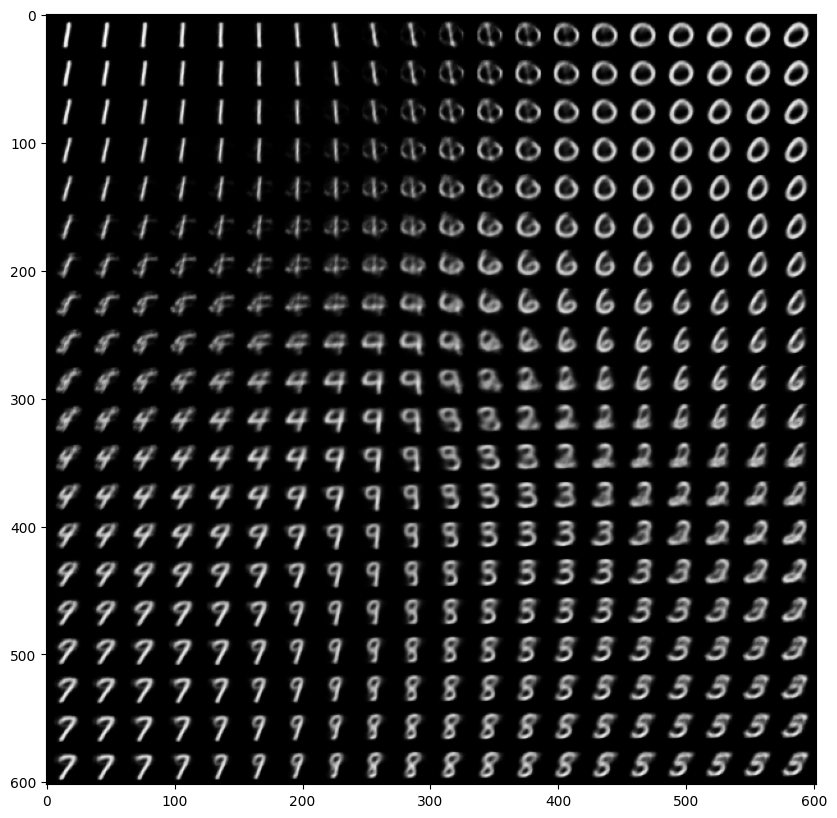

In [10]:
def sample2d(epoch):
    model.eval()
    eps = torch.FloatTensor(400, 2)
    nx = ny = 20
    x_values = np.linspace(-2, 2, nx)
    y_values = np.linspace(-2, 2, ny)
    for i in range(nx):
        for j in range(ny):
            eps[i*20+j][0] = x_values[i]
            eps[i*20+j][1] = y_values[j]
          
    eps = eps.to(device)
    fake = model.decode(eps)
    save_image(fake.view(400, 1, 28, 28),
               'results/grid_' + str(epoch) + '.png', nrow=20)
    
sample2d(50)
im = plt.imread('results/grid_50.png')
plt.figure(figsize=(10,10))
plt.imshow(im)